### INTRO
#### WHY?
- 사람의 사진을 기반으로 퍼스널 컬러를 예측하여 그에 맞는 화장을 해주거나 스마트 렌즈, 자율주행 자동차 등 **computer vision**기술에 유난히 관심이 많았다.
- 그래서 그렇게 하기 위해서는 간단한 CNN부터 OpenCV까지 모두 다루어 보고 싶었고 일단 라벨링이 잘 되어 있는 이미지 데이터를 가지고 학습을 해 보는 것이 우선이라고 생각했다.
- 항상 이미지 데이터를 다루기 시작하기 전에 데이터를 전처리하고 데이터셋을 로드하며 입력 pipeline을 구축하는 것이 너무 어렵고 까다로웠다.
- 이번에는 이미지 전처리를 위해서 ImageDataGenerator을 이용해 보기로 했다.

- 3개의 총 다른 모델을 이용해서 학습을 시켜 보았는데, 세가지 모두 조금씩 다르게, 각각 다른 방법의 함수형 API를 사용하였다. 
- 그리고 마지막 model의 경우에는 ResNet의 스킵학습을 Class를 이용해서 구현하여서 학습을 시켜 보았다.

In [1]:
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

In [2]:
print(tf.__version__) 
tf.test.is_gpu_available()

2.1.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [6]:
import os
def makefile_name(dir):
    file = []
    filenames = os.listdir(dir)
    for name in filenames:
        file.append(os.path.join(dir, name))
    return file

In [7]:
#이미지 데이터(makefile_name(directory)를 이용해서 저장 경로 저장)
img_root = "C:\\Users\\이지혜\\.keras\\datasets\\img_align_celeba"
img_file = makefile_name(img_root)

In [4]:
img_file[:5]

['C:\\Users\\이지혜\\.keras\\datasets\\img_align_celeba\\000001.jpg',
 'C:\\Users\\이지혜\\.keras\\datasets\\img_align_celeba\\000002.jpg',
 'C:\\Users\\이지혜\\.keras\\datasets\\img_align_celeba\\000003.jpg',
 'C:\\Users\\이지혜\\.keras\\datasets\\img_align_celeba\\000004.jpg',
 'C:\\Users\\이지혜\\.keras\\datasets\\img_align_celeba\\000005.jpg']

### 1. Gender Prediction

In [2]:
#특징들의 여부나 성별의 구분이 담긴 데이터
data_dir = "C:\\Users\\이지혜\\.keras\\datasets\\list_attr_celeba.csv"
data_df = pd.read_csv(data_dir)

In [9]:
data_df.head()

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [10]:
data_df.columns

Index(['image_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows',
       'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
       'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
       'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
       'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
       'Wearing_Necktie', 'Young'],
      dtype='object')

In [11]:
hair_data = data_df.get(["Black_Hair", "Blond_Hair", "Brown_Hair"])

In [12]:
hair_data["Black_Hair"].value_counts()

-1    154127
 1     48472
Name: Black_Hair, dtype: int64

In [13]:
hair_data["Blond_Hair"].value_counts()

-1    172616
 1     29983
Name: Blond_Hair, dtype: int64

In [14]:
hair_data["Brown_Hair"].value_counts()

-1    161027
 1     41572
Name: Brown_Hair, dtype: int64

In [3]:
gender_data = data_df.get(["image_id", "Male"])

In [22]:
len(img_file)

18648

In [16]:
gender_data.head()

,image_id,Male
0,000001.jpg,-1
1,000002.jpg,-1
2,000003.jpg,1
3,000004.jpg,-1
4,000005.jpg,-1


**성별 예측과 함께 머리 색도 예측을 해줄 것이기 때문에 'Male'이라는 데이터와 'Black_Hair', 'Blonde_Hair', 'Brown_Hair'데이터를  이용해 주고자 한다.**

**모든 이미지의 크기가 (218,178)의 픽셀로 이루어져 있기 때문에 (178,178)의 크기로 다시 조정을 해 주었다**

In [66]:
import cv2
#이미지 로드(array의 형태로 바꾸어 놓음)
def load_image(dir):
    img = tf.io.read_file(dir)
    img = tf.image.decode_jpeg(img, channels = 3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, (200, 200))
    return img

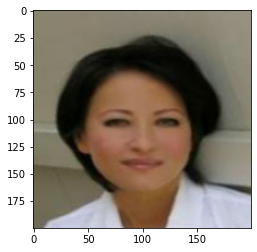

In [18]:
plt.imshow(load_image(img_file[100]))

- 분류를 해 주어야 하는데, 우선 성별에 따라서 여성/남성으로 나누어 준 뒤에 각각의 분류 내에서 검은/갈색/금발 머리로 나누어 주어야 한다. 
- 따라서 분류기는 **다중 레이블 분류(multi label classification)**를 하는 것이다.
    - 따라서 각 이미지마다 두개의 타깃 레이블이 담긴 y_multilable배열을 만들어야 하는 것이다.
    - 이를 위해서 ```from sklearn.neighbors import KNeighborsClassifier```을 이용해도 된다. 왜냐하면 다른 sklearn의 분류기들은 다중 레이 블 분류를 지원해 주지 않기 때문이다.
    
- 다중 레이블 분류로 이를 학습시키기 위해서는 합성곱 신경망 층까지는 그대로 진행하다가 이후에 마지막 Dense layer에서 출력을 다르게 한 뒤에 다시 해당 레이블을 합쳐서 금발 남자, 금발 여자, 흑발 여자, 흑발 남자, 갈색 여자, 갈색 남자 이런 식으로 6개의 label을 출력하도록 할 지 고민이다.
- 처음부터 그냥 6개의 레이블로 나누어 준다면 좋겠지만 이왕이면 따로 해서 정확도를 높여주는 것이 나을 것 같다는 생각이 든다.  
**이런 다중 레이블 분류의 문제는 함수형 API나 subclassing API를 이용하면 쉽게 해결이 가능하다**

----------------------------------------------------------------------------------------------------------------------------------------

** 위와 같이 진행하려 했으나 머리 색을 나타내는 데이터중에 여러개의 머리색을 나타내는 이미지도 있고 무엇보다 머리색이 지정되지 않은 데이터가 반절이었기 때문에 그냥 성별 데이터만 학습하기로 했다.**

- 이제 이진 분류로 바뀐 상태이기 때문에 Convolution Layer, Dense Layer을 각각 class로 만들어서 합친뒤에 하나의 Model로 만들어서 loss는 binary_crossentropy, optimizer는 Adam을 이용할 생각이다.

### 1. Dataset 경로 이동하기
- 이진분류를 하면 되는 것이니까 이제 그냥 Image Data Generator Flow from Directory를 이용할 생각이다.
- 이를 위해서 Flow From Directory의 특성상 저장 경로의 하위항목으로 train -> male / female 이런 식으로 나누어 주어야만 label이 자동으로 생성이 된다.

In [4]:
gender = np.array(gender_data["Male"])
img = np.array(gender_data["image_id"])

In [8]:
import os
male_dir, female_dir = [],[]
for i in range(len(gender)):
    if i < len(img_file):
        path = os.path.join(img_root, img[i])
        if gender[i] == -1:
            female_dir.append(path)
        else:male_dir.append(path)

In [9]:
len(female_dir), len(male_dir)

(10802, 7846)

In [10]:
female_dir = female_dir[:len(male_dir)]

In [50]:
len(female_dir), len(male_dir)

(7846, 7846)

In [51]:
train = female_dir + male_dir

In [11]:
from sklearn.model_selection import train_test_split
train_fe, test_fe, train_ma, test_ma = train_test_split(female_dir, male_dir, test_size = 0.3, shuffle = True)

In [56]:
len(train_fe),len(train_ma), len(test_fe), len(test_ma)

(5492, 5492, 2354, 2354)

In [33]:
train_fe[0].split('\\')

['C:', 'Users', '이지혜', '.keras', 'datasets', 'img_align_celeba', '000445.jpg']

In [ ]:
import shutil
name = ["female", "male"]
for i in range(2):
    os.mkdir(os.path.join("H:\\train", name[i]))
    os.mkdir(os.path.join("H:\\test", name[i]))

In [58]:
def copy_file(file, root):
    for i in file:
        name = i.split('\\')[-1]
        new_dir = os.path.join(root, name)
        shutil.copyfile(i, new_dir)

In [59]:
copy_file(train_fe, 'H:\\train\\female')
copy_file(train_ma, 'H:\\train\\male')
copy_file(test_fe, 'H:\\test\\female')
copy_file(test_ma, 'H:\\test\\male')

### 2. Dataset 만들기

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode="nearest",
    horizontal_flip=True,
    validation_split=0.2,
    dtype=tf.float32,
    rescale = 1/255.0
)
test_datagen = ImageDataGenerator(
    rescale = 1/255.0
)

In [13]:
train_data = train_datagen.flow_from_directory(
    directory = 'H:\\train',
    target_size = (200,200),
    color_mode="rgb",
    class_mode="binary",
    batch_size=32,
    shuffle=True,
    seed = None,
    save_to_dir=None,
    subset=None,
    interpolation="nearest",
)
test_data = test_datagen.flow_from_directory(
    directory = 'H:\\test',
    target_size = (200,200),
    color_mode = 'rgb',
    class_mode = 'binary'
)

Found 10984 images belonging to 2 classes.
Found 4708 images belonging to 2 classes.


### 3. Model 만들기
#### Model-1
- 우선 직접 모델(내가 설계한)을 이용해서 학습을 해보고 이후에는 ResNet-34의 원리를 이용한 모델로 학습을 해서 학습률을 비교해볼 생각이다.
- 사실 만약에 Convolution layer에서 padding = 'valid'라고 한다면 이미지의 크기가 저절로 0으로 채워지지 않기 때문에 작은 크기를 이용할 수 있다. 그러나 padding = 'same'으로 한 뒤에 MaxPool2D를 사용하게 되면 kernel의 크기를 2, 즉 제일 작은 크기로 하더라도 데이터의 손실이 꽤나 크다. 왜냐하면 출력은 양방향으로 줄어서 결국 입력값의 1/4만 남게 되기 때문이다. 
    - 따라서 MaxPooling층은 작은 변화에도 일정 수준의 불변성을 만들어주는 역할을 하기 때문에 **몇개의 층마다 추가**해주는 것이 좋다. 

In [17]:
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, BatchNormalization, Dropout
from tensorflow.keras.activations import relu, sigmoid, softmax
from tensorflow.keras.optimizers import Adam

In [113]:
inputs = tf.keras.Input(shape = (200,200,3))
x = Conv2D(32, 3, activation = 'relu', strides = 2)(inputs)
x = Conv2D(64, 3, activation = 'relu', strides = 2)(x)
block_1_output = MaxPool2D(4)(x)

x = Conv2D(64, 3, activation = 'relu', padding = 'same')(block_1_output)
x = Conv2D(64, 3, activation = 'relu', padding = 'same')(x)
block_2_output = tf.keras.layers.add([x, block_1_output])

x = Conv2D(128, 3, activation = 'relu', padding = 'same')(block_2_output)
x = Flatten()(x)
x = Dropout(0.4)(x)
x = Dense(256, activation = 'relu')(x)
x = Dense(32, activation = 'relu')(x)
outputs = Dense(1, activation = 'sigmoid')(x)

model = tf.keras.Model(inputs, outputs, name = 'my_model')


In [114]:
model.summary()

Model: "my_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
conv2d_43 (Conv2D)              (None, 99, 99, 32)   896         input_9[0][0]                    
__________________________________________________________________________________________________
conv2d_44 (Conv2D)              (None, 49, 49, 64)   18496       conv2d_43[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_7 (MaxPooling2D)  (None, 12, 12, 64)   0           conv2d_44[0][0]                  
___________________________________________________________________________________________

In [115]:
model.compile(optimizer = tf.keras.optimizers.RMSprop(lr=0.001), loss = 'binary_crossentropy', metrics = ['accuracy'])
my_model_hist = model.fit(train_data, epochs = 20)

  ...
    to  
  ['...']
Train for 344 steps
Epoch 1/20
344/344 [==============================] - 186s 540ms/step - loss: 0.6170 - accuracy: 0.6803
Epoch 2/20
344/344 [==============================] - 139s 404ms/step - loss: 0.5167 - accuracy: 0.7489
Epoch 3/20
344/344 [==============================] - 141s 411ms/step - loss: 0.4516 - accuracy: 0.7920
Epoch 4/20
344/344 [==============================] - 150s 437ms/step - loss: 0.3875 - accuracy: 0.8308
Epoch 5/20
344/344 [==============================] - 144s 420ms/step - loss: 0.3307 - accuracy: 0.8597
Epoch 6/20
344/344 [==============================] - 141s 409ms/step - loss: 0.2956 - accuracy: 0.8778
Epoch 7/20
344/344 [==============================] - 158s 458ms/step - loss: 0.2702 - accuracy: 0.8928
Epoch 8/20
344/344 [==============================] - 145s 420ms/step - loss: 0.2641 - accuracy: 0.8949
Epoch 9/20
344/344 [==============================] - 158s 460ms/step - loss: 0.2486 - accuracy: 0.9065
Epoch 10/20
344/344

In [141]:
model.evaluate(test_data)

  ...
    to  
  ['...']
148/148 [==============================] - 14s 94ms/step - loss: 0.2262 - accuracy: 0.9416


[0.22624085674918182, 0.94158876]

**Accuracy = 94.16%**

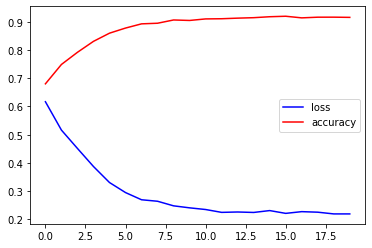

In [144]:
plt.figure(figsize = (6,4))
plt.plot(my_model_hist.history['loss'], 'b-',label = 'loss')
plt.plot(my_model_hist.history['accuracy'], 'r-', label = 'accuracy')
plt.legend()
plt.show()


#### Model-2.

In [154]:
class my_Model(tf.keras.Model):
    
    #__intit__는 모든 모델에 대한 정도를 담고있는 일종의 생성자 역할을 한다.
    def __init__(self,filters, strides = 2, activation = 'relu', **kwargs):
        super(my_Model, self).__init__(**kwargs) #표준 매개변수를 처리하는 역할
        self.first_layer = Conv2D(filters, 4, activation = 'relu', strides = strides, padding = 'same', use_bias = True)
        self.main_layers = [
            #이 경우에는 class로 layer을 직접 custom 한 것은 아니기 때문에 add_weights()는 넣어줄 필요가 없었다.
            Conv2D(filters, 4, activation = 'relu', strides = strides, padding = 'same', use_bias = True),
            MaxPool2D(4),
            BatchNormalization(),
            Conv2D(filters*2, 4, activation = 'relu', strides = strides, padding = 'same', use_bias = True),
            MaxPool2D(4),
            BatchNormalization(),
            Flatten(),
            Dropout(0.3),
            Dense(256, activation = 'relu'),
            Dense(32, activation = 'relu'),
            Dense(1, activation = 'sigmoid')
        ]
        
    #call()는 정의 하고 있는 층이나 모델이 어느 층으로 input을 받아서 어떤 output을 출력할지 결정해주는 역할을 한다.
    #즉, model을 fit()하게 되면 어떤 경로로 학습을 하게 될지 지정해 주는 것이다.
    def call(self, inputs):
        x = self.first_layer(inputs)
        for layer in self.main_layers:
            x = layer(x)
        return x
        

In [155]:
my_Model = my_Model(32)

In [158]:
my_Model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0002), metrics = ['accuracy'], loss = 'binary_crossentropy')

In [159]:
my_Model.fit(train_data, epochs = 10)

  ...
    to  
  ['...']
Train for 344 steps
Epoch 1/10
344/344 [==============================] - 131s 381ms/step - loss: 0.6733 - accuracy: 0.5882
Epoch 2/10
344/344 [==============================] - 136s 396ms/step - loss: 0.6396 - accuracy: 0.6301
Epoch 3/10
344/344 [==============================] - 132s 384ms/step - loss: 0.5965 - accuracy: 0.6781
Epoch 4/10
344/344 [==============================] - 135s 392ms/step - loss: 0.5694 - accuracy: 0.7033
Epoch 5/10
344/344 [==============================] - 154s 449ms/step - loss: 0.5478 - accuracy: 0.7218
Epoch 6/10
344/344 [==============================] - 173s 503ms/step - loss: 0.5335 - accuracy: 0.7311
Epoch 7/10
344/344 [==============================] - 147s 428ms/step - loss: 0.5115 - accuracy: 0.7444
Epoch 8/10
344/344 [==============================] - 135s 393ms/step - loss: 0.4890 - accuracy: 0.7653
Epoch 9/10
344/344 [==============================] - 134s 390ms/step - loss: 0.4562 - accuracy: 0.7856
Epoch 10/10
344/344

In [160]:
my_Model.summary()

Model: "my__model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_66 (Conv2D)           multiple                  1568      
_________________________________________________________________
conv2d_67 (Conv2D)           multiple                  16416     
_________________________________________________________________
max_pooling2d_21 (MaxPooling multiple                  0         
_________________________________________________________________
batch_normalization_15 (Batc multiple                  128       
_________________________________________________________________
conv2d_68 (Conv2D)           multiple                  32832     
_________________________________________________________________
max_pooling2d_22 (MaxPooling multiple                  0         
_________________________________________________________________
batch_normalization_16 (Batc multiple                  

In [161]:
my_Model.evaluate(test_data)

  ...
    to  
  ['...']
148/148 [==============================] - 13s 91ms/step - loss: 0.3694 - accuracy: 0.8432


[0.3694020175450557, 0.84324557]

**Accuracy = 84.32%**

#### Model-3.
#### ResNet-34 Model 만들기
- ResNet-34 모델을 keras의 사전 제공되는 모델을 사용하지 않고 직접 keras의 함수형 API를 이용해서 구현하려고 노력했다.
- 물론 데이터의 양이 너무 적기 때문에 ResNet-34의 알고리즘을 사용하게 되면 과대적합이 될 수 있다고 생각하지만, 한번 시도를 해볼 예정이다(의외로 학습이 제일 잘 될 수도)

- ResNet는 깊은 층의 CNN layer을 사용하지만, **스킵 연결**이라는 것을 추가하게 된다.
- 이는 일부 층이 아직 학습이 되지 않았더라도 네트워크가 훈련을 할 수 있도록 한다.

In [18]:
class ResidentialUnit(tf.keras.layers.Layer):
    def __init__(self,filters, strides, activation = 'relu',**kwargs):
        super(ResidentialUnit, self).__init__(**kwargs)
        self.activation = tf.keras.activations.get(activation)
        self.main_layers = [
            Conv2D(filters, kernel_size = 3, strides = strides, padding = 'same', use_bias = False, activation = self.activation),
            BatchNormalization(),
            Conv2D(filters, kernel_size = 3, strides = 1, padding = 'same', use_bias = False, activation = self.activation),
            BatchNormalization()
        ]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                Conv2D(filters, kernel_size = 3, strides = strides, padding = 'same', use_bias = False),
                BatchNormalization()
            ]
            
    def call(self, inputs):
        x = inputs
        for layer in self.main_layers:
            x = layer(x)
        skip_x = inputs
        for layer in self.skip_layers:
            skip_x = layer(skip_x)
        return self.activation(x+skip_x)

In [19]:
ResModel = tf.keras.models.Sequential()
ResModel.add(Conv2D(32, 3, strides = 2, input_shape = [200,200,3], padding = 'same', activation = 'relu', use_bias = False))
ResModel.add(BatchNormalization())
ResModel.add(MaxPool2D(3, strides = 2, padding = 'same'))
prev_filters = 32
for filters in [32]*3 + [64]*4:
    strides = 1 if filters == prev_filters else 2
    ResModel.add(ResidentialUnit(filters, strides = strides))
    prev_filters = filters
ResModel.add(Flatten())
ResModel.add(Dropout(0.4))
ResModel.add(Dense(128, activation = 'relu'))
ResModel.add(Dense(32, activation = 'relu'))
ResModel.add(Dense(1, activation = 'sigmoid'))

In [20]:
ResModel.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 32)      864       
_________________________________________________________________
batch_normalization (BatchNo (None, 100, 100, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 32)        0         
_________________________________________________________________
residential_unit (Residentia (None, 50, 50, 32)        18688     
_________________________________________________________________
residential_unit_1 (Resident (None, 50, 50, 32)        18688     
_________________________________________________________________
residential_unit_2 (Resident (None, 50, 50, 32)        18688     
_________________________________________________________________
residential_unit_3 (Resident (None, 25, 25, 64)       

In [22]:
ResModel.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0002), metrics = ['accuracy'])
ResModel.fit(train_data, epochs = 5)

  ...
    to  
  ['...']
Train for 344 steps
Epoch 1/5
344/344 [==============================] - 303s 882ms/step - loss: 0.6890 - accuracy: 0.6536
Epoch 2/5
344/344 [==============================] - 345s 1s/step - loss: 0.5355 - accuracy: 0.7334
Epoch 3/5
344/344 [==============================] - 345s 1s/step - loss: 0.4642 - accuracy: 0.7852
Epoch 4/5
344/344 [==============================] - 345s 1s/step - loss: 0.4197 - accuracy: 0.8129
Epoch 5/5
344/344 [==============================] - 345s 1s/step - loss: 0.3829 - accuracy: 0.8303


In [23]:
ResModel.evaluate(test_data)

  ...
    to  
  ['...']
148/148 [==============================] - 47s 315ms/step - loss: 0.3149 - accuracy: 0.8670


[0.3148550973903086, 0.86703485]

**Accuracy = 86.70%**
- 몇번 더 학습 시켰으면 훨씬 높았겠지만 CNN층이 깊어서 시간이 오래 걸리는 관계로 이정도만 해 주었다.